In [5]:
%run ../../Environment/environment.ipynb

Notebook ausgeführt


In [6]:
import gym
import numpy as np
import pandas as pd
import joblib
import random
from stable_baselines3 import PPO, A2C, DQN
from stable_baselines3.common.callbacks import CheckpointCallback
from sklearn.preprocessing import StandardScaler
from stable_baselines3.common.vec_env import DummyVecEnv


In [7]:
seed = 42
SEED  = seed % (2**32 - 1)
print(f"SEED: {SEED}")

SEED: 42


In [8]:
# -------------------------------
# CSV Datem einlesen
# -------------------------------
train_data = pd.read_csv("../../Transform_data/stand_data/2023-2018_stand_data.csv")
train_data.drop('datetime', axis=1, inplace=True)

test_data = pd.read_csv("../../Transform_data/stand_data/2025-2024_stand_data.csv")
test_data.drop('datetime', axis=1, inplace=True)

if(train_data is not None and test_data is not None):
    print("Daten erfolgreich eingelesen")

Daten erfolgreich eingelesen


In [9]:
# -------------------------------
# TradingEnv erstellen (bitte sicherstellen, dass TradingEnv importiert oder im gleichen Skript definiert ist)
# -------------------------------
env = TradingEnv(
    data=train_data,
    initial_cash=10_000,
    window_size=336,
    scaler_path="../../Transform_data/scaler.pkl",
    default_seed=SEED
)

if(env is not None):
    print("Environment created successfully")

Seed in the environment: 42
Environment created successfully


/home/lucifer/.local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [10]:
# -------------------------------
# PPO-Agenten initialisieren
# -------------------------------
model = A2C(
    "MlpPolicy",
    env,  # Normalisiert die Vorteile (Advantages) für stabileres Lernen
    verbose=1
)

# Optional: Checkpoint Callback um den Trainingsfortschritt zwischendurch zu speichern
checkpoint_callback = CheckpointCallback(save_freq=100, save_path='./logs/', name_prefix='ppo_trading')

# -------------------------------
# Training
# -------------------------------
model.learn(
    total_timesteps=100, 
    #callback=checkpoint_callback, 
    log_interval=1
)

# Speichere das trainierte Modell
model.save("ppo_trading_model")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Seed in the environment: 42
---------------------------
| time/              |    |
|    fps             | 95 |
|    iterations      | 1  |
|    time_elapsed    | 0  |
|    total_timesteps | 5  |
---------------------------
------------------------------------
| time/                 |          |
|    fps                | 114      |
|    iterations         | 2        |
|    time_elapsed       | 0        |
|    total_timesteps    | 10       |
| train/                |          |
|    entropy_loss       | -2.2     |
|    explained_variance | -974     |
|    learning_rate      | 0.0007   |
|    n_updates          | 1        |
|    policy_loss        | 2.2      |
|    value_loss         | 1.28     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 138      |
|    iterations         | 3        |
|    time_elapse

# Backtesting

## Trainigsdaten

Seed in the environment: 42


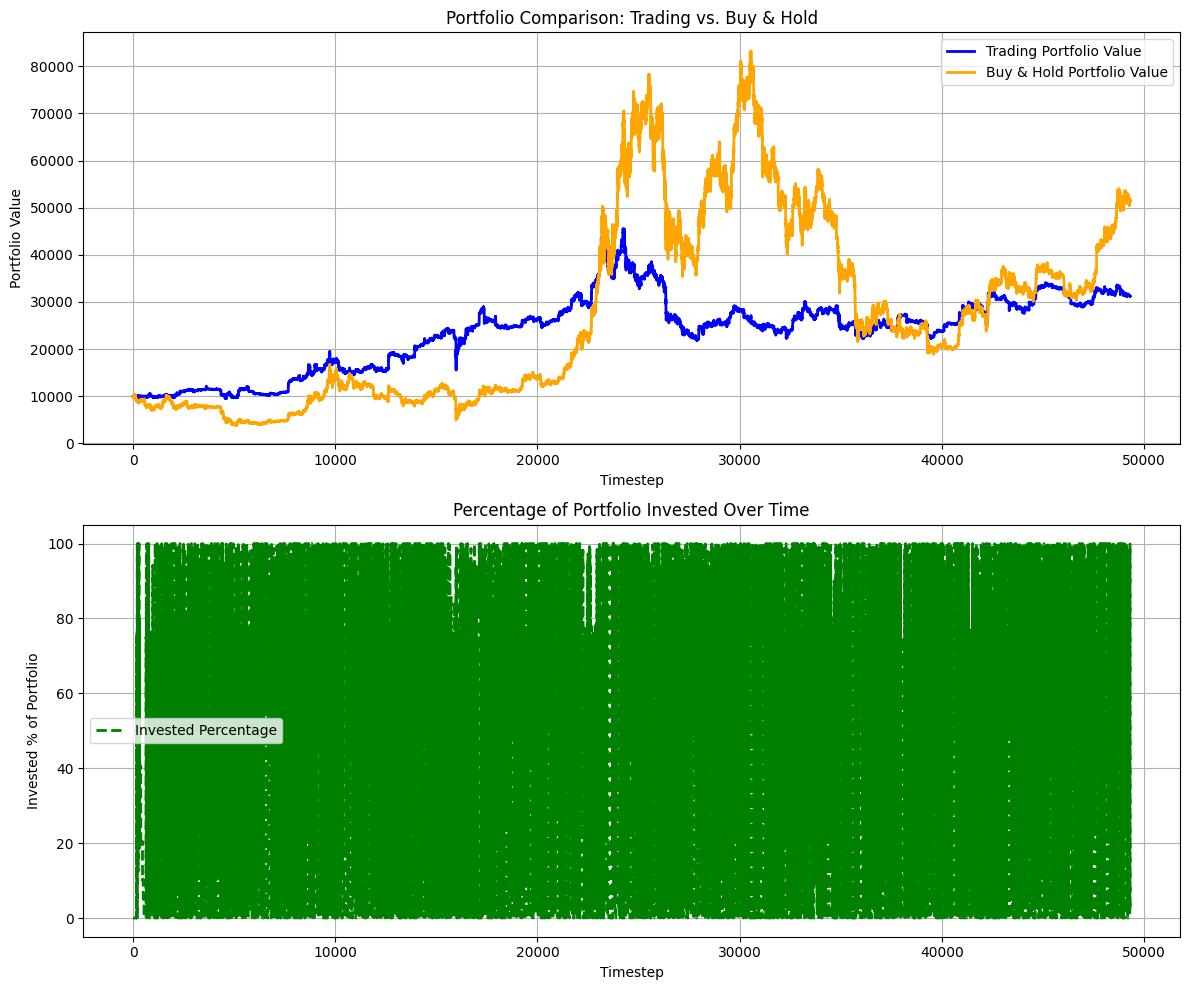

[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 6, 6, 0, 0, 0, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 0, 0, 0, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 6, 6, 6, 6, 5, 6, 0, 0, 6, 0, 6, 0, 0, 0, 0, 0, 0, 6, 6, 6, 6, 6, 6, 0, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 6, 3, 3, 3, 3, 6, 3, 6, 3, 0, 0, 3, 3, 3, 3, 0, 0, 3, 0, 6, 6, 6, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 3, 0, 6, 0, 0, 

In [11]:
# -------------------------------
# Testlauf: Den trainierten Agenten in einer Episode ausführen
# -------------------------------
training_env = env

obs, info = training_env.reset(seed=SEED)
done = False

# Liste der actionen
action_list = []

while not done:
    # Bestimme die Aktion (deterministisch)
    action, _states = model.predict(obs, deterministic=True)
    action = int(action)  # oder: action = action.item()
    obs, reward, done, truncated, info = training_env.step(action)
    action_list.append(action)

# Hier wird der Zustand gerendert (z.B. als Plot). Du kannst den Render-Modus anpassen.
training_env.render(mode='human')
print(action_list)

## Testdaten

Seed in the environment: 42
Seed in the environment: 42


/home/lucifer/.local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


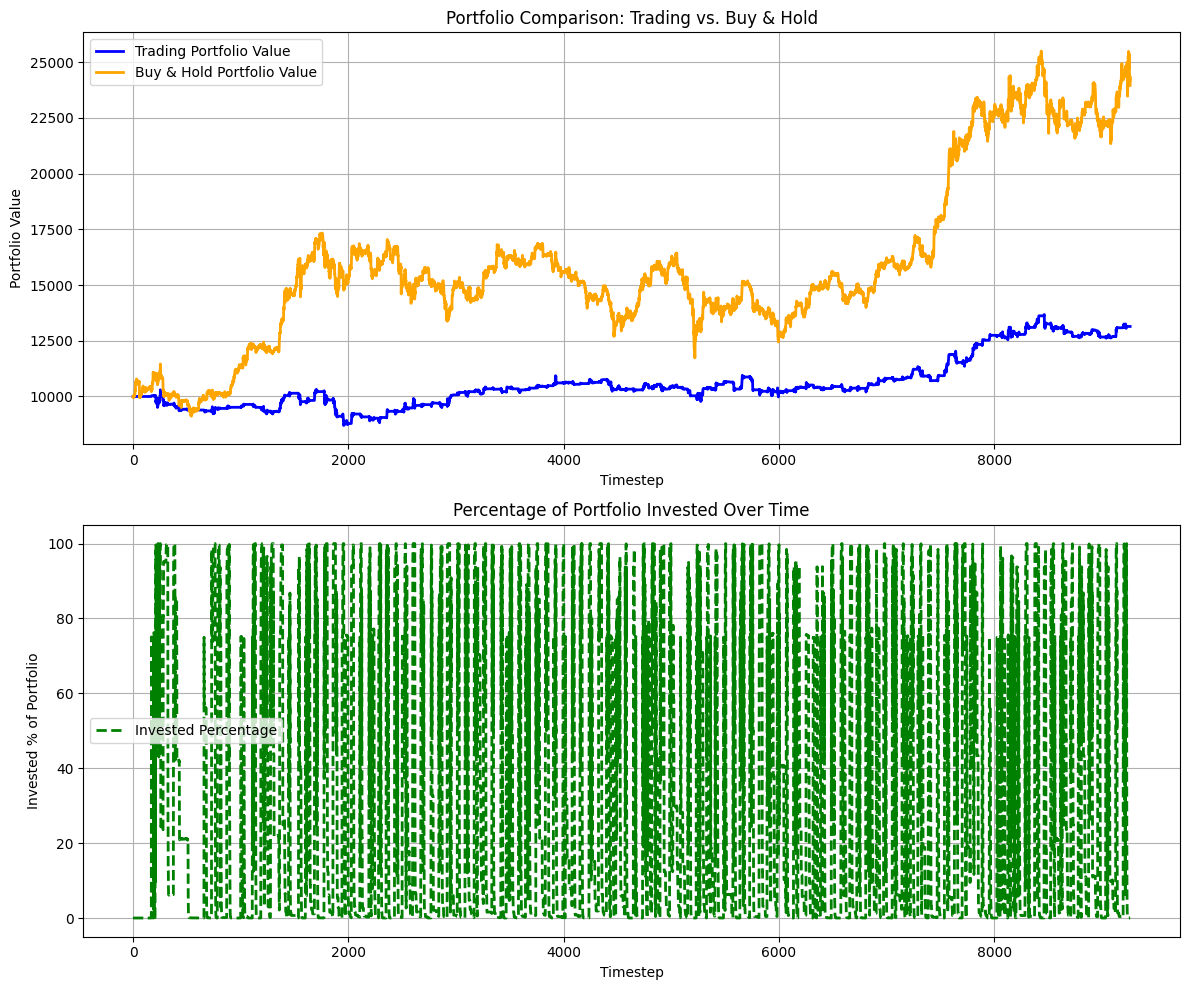

[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 6, 6, 0, 0, 0, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 0, 0, 0, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 6, 6, 6, 6, 5, 6, 0, 0, 6, 0, 6, 0, 0, 0, 0, 0, 0, 6, 6, 6, 6, 6, 6, 0, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 0, 0, 0, 3, 6, 3, 6, 3, 6, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 0, 0, 3, 3, 6, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 6, 6, 0, 6, 0, 6, 0, 0, 0, 0, 

In [12]:
# -------------------------------
# Testlauf: Den trainierten Agenten in einer Episode ausführen
# -------------------------------
test_env = TradingEnv(
    data=test_data,
    initial_cash=10_000,
    window_size=336,
    scaler_path="../../Transform_data/scaler.pkl",
    default_seed=SEED
)

obs, info = test_env.reset(seed=SEED)
done = False

# Liste der actionen
action_list = []

while not done:
    # Bestimme die Aktion (deterministisch)
    action, _states = model.predict(obs, deterministic=True)
    action = int(action)  # oder: action = action.item()
    obs, reward, done, truncated, info = test_env.step(action)
    action_list.append(action)

# Hier wird der Zustand gerendert (z.B. als Plot). Du kannst den Render-Modus anpassen.
test_env.render(mode='human')
print(action_list)